<a href="https://colab.research.google.com/github/fjadidi2001/AD_Prediction/blob/main/HandwrittenFianl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pytorch_tabnet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 1.8 MB/s eta 0:00:00


Enhanced Alzheimer's Detection System with TabNet + XGBoost Fusion


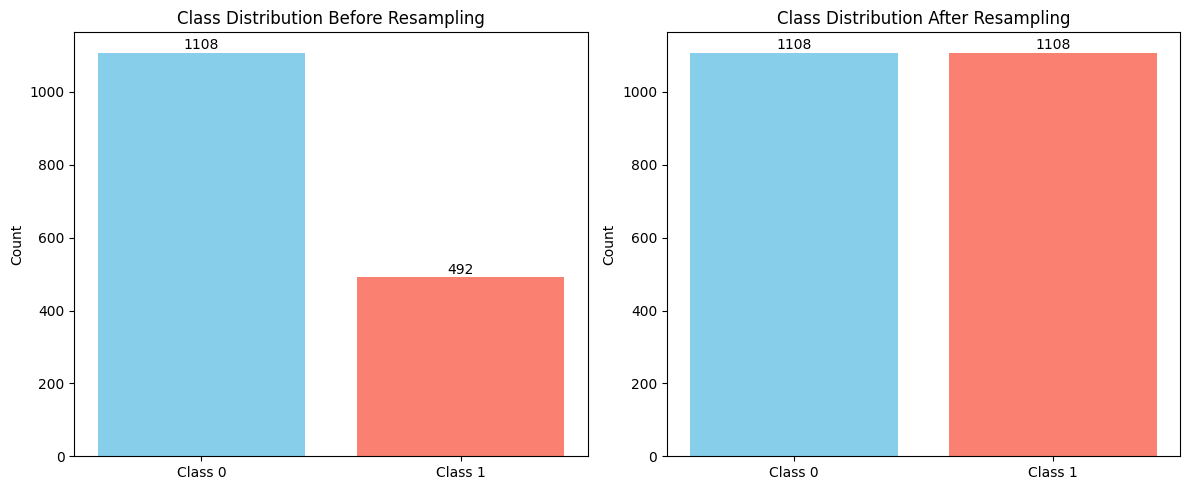

epoch 0  | loss: 0.58253 | validation_auc: 0.90244 |  0:00:01s
epoch 1  | loss: 0.20463 | validation_auc: 0.935   |  0:00:01s
epoch 2  | loss: 0.15942 | validation_auc: 0.95345 |  0:00:02s
epoch 3  | loss: 0.12098 | validation_auc: 0.98142 |  0:00:02s
epoch 4  | loss: 0.09984 | validation_auc: 0.98201 |  0:00:02s
epoch 5  | loss: 0.08983 | validation_auc: 0.98676 |  0:00:03s
epoch 6  | loss: 0.0749  | validation_auc: 0.98488 |  0:00:03s
epoch 7  | loss: 0.06652 | validation_auc: 0.98418 |  0:00:03s
epoch 8  | loss: 0.04977 | validation_auc: 0.98829 |  0:00:03s
epoch 9  | loss: 0.05194 | validation_auc: 0.98896 |  0:00:04s
epoch 10 | loss: 0.04579 | validation_auc: 0.98935 |  0:00:04s
epoch 11 | loss: 0.04923 | validation_auc: 0.98984 |  0:00:04s
epoch 12 | loss: 0.04094 | validation_auc: 0.98973 |  0:00:05s
epoch 13 | loss: 0.04074 | validation_auc: 0.99008 |  0:00:05s
epoch 14 | loss: 0.04264 | validation_auc: 0.99078 |  0:00:05s
epoch 15 | loss: 0.04221 | validation_auc: 0.99028 |  0

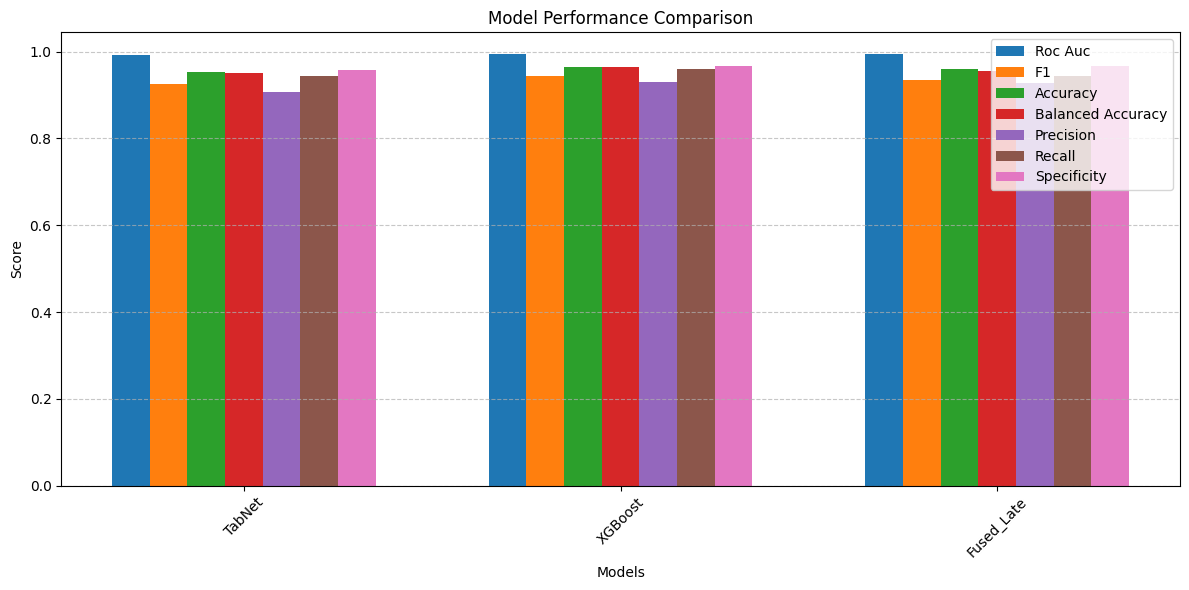

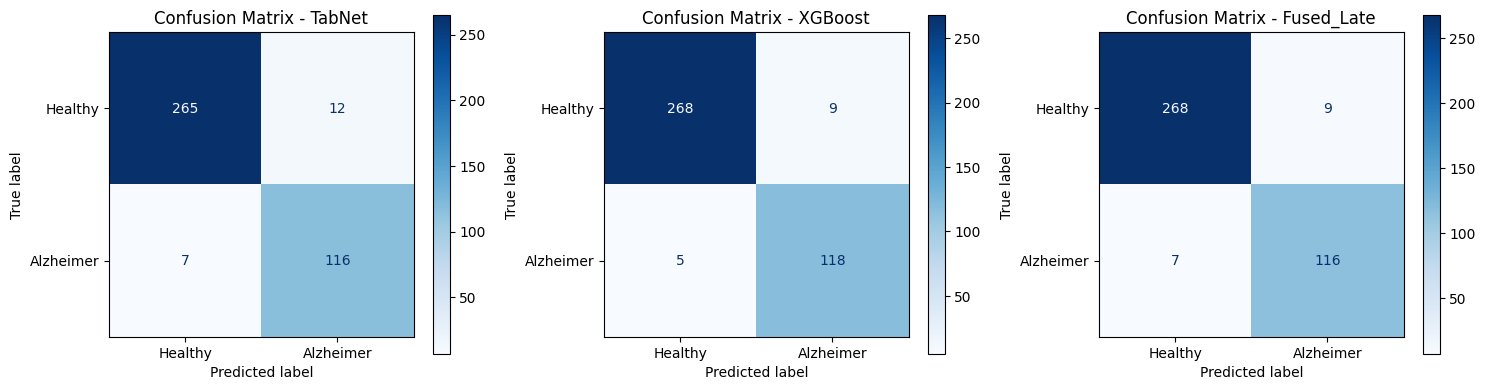

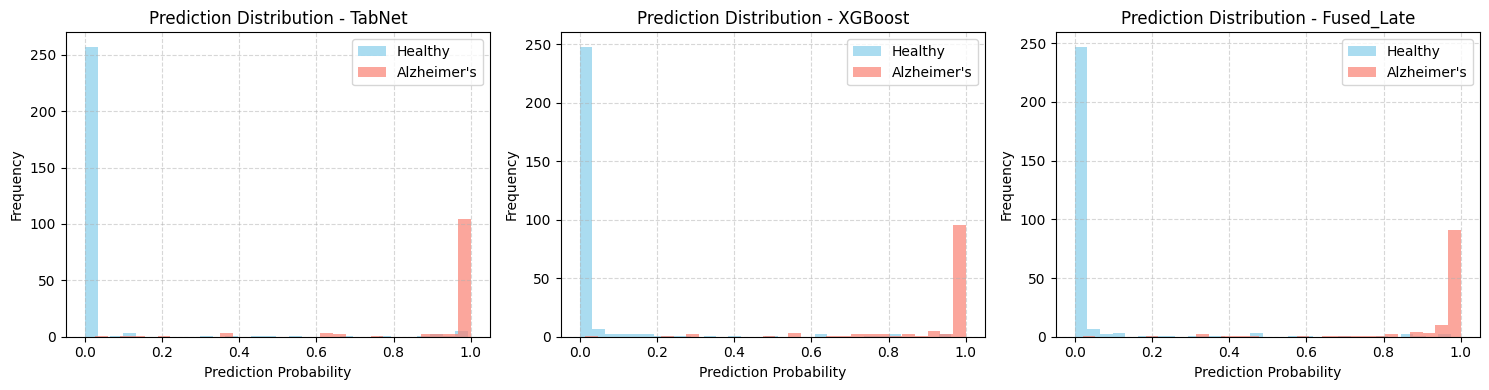


Analysis completed successfully!

FINAL MODEL COMPARISON (Test Set Metrics):
--------------------------------------------------

TabNet:
  ROC AUC:       0.9928
  F1 Score:      0.9243
  Accuracy:      0.9525
  Balanced Acc:  0.9499
  Precision:     0.9062
  Recall/Sens:   0.9431
  Specificity:   0.9567

XGBoost:
  ROC AUC:       0.9945
  F1 Score:      0.9440
  Accuracy:      0.9650
  Balanced Acc:  0.9634
  Precision:     0.9291
  Recall/Sens:   0.9593
  Specificity:   0.9675

Fused_Late:
  ROC AUC:       0.9940
  F1 Score:      0.9355
  Accuracy:      0.9600
  Balanced Acc:  0.9553
  Precision:     0.9280
  Recall/Sens:   0.9431
  Specificity:   0.9675

Analysis complete! Check the visualizations and results above.


In [2]:
# --- STEP 1: IMPORTS ---
import pandas as pd
import numpy as np
import torch
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.metrics import (
    roc_auc_score, roc_curve, precision_recall_curve,
    f1_score, confusion_matrix, accuracy_score,
    classification_report, balanced_accuracy_score,
    precision_score, recall_score
)
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import shap
import warnings
import os
import logging
from pathlib import Path
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import xgboost as xgb
from sklearn.metrics import ConfusionMatrixDisplay
import itertools # For combinations in plotting

warnings.filterwarnings('ignore')

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# --- STEP 2: DEFINE THE ENHANCED CLASS ---
class EnhancedAlzheimerDetectorWithFusion:
    """
    Enhanced Alzheimer's Detection using TabNet + XGBoost with Fusion and advanced preprocessing
    """
    def __init__(self, random_state=42):
        self.random_state = random_state
        self.scaler = None
        self.label_encoder = LabelEncoder()
        self.feature_selector = None
        self.tabnet_model = None
        self.xgb_model = None # New XGBoost model
        self.original_features = None
        self.selected_features = None
        self.preprocessing_stats = {}
        # Set random seeds for reproducibility
        np.random.seed(random_state)
        torch.manual_seed(random_state)

    # --- STEP 3: DATA LOADING ---
    def load_data(self, data_path=None):
        """Enhanced data loading with validation"""
        try:
            # Prioritize the provided path
            if data_path and os.path.exists(data_path):
                logger.info(f"Loading data from provided path: {data_path}")
                data = pd.read_csv(data_path)
                logger.info(f"Dataset shape: {data.shape}")
                logger.info(f"Dataset columns (first 10): {list(data.columns)[:10]}...")
                return data
            # Try common default paths
            possible_paths = [
                'data.csv',
                './data/data.csv',
                '../data/data.csv',
                '/root/.cache/kagglehub/datasets/taeefnajib/handwriting-data-to-detect-alzheimers-disease/versions/1/data.csv'
            ]
            data = None
            for path in possible_paths:
                if path and os.path.exists(path):
                    logger.info(f"Loading data from: {path}")
                    data = pd.read_csv(path)
                    break
            if data is None:
                logger.warning("Dataset not found. Creating enhanced sample data.")
                data = self._create_enhanced_sample_data()
            logger.info(f"Dataset shape: {data.shape}")
            logger.info(f"Dataset columns (first 10): {list(data.columns)[:10]}...")
            return data
        except Exception as e:
            logger.error(f"Error loading data: {e}")
            return self._create_enhanced_sample_data()

    def _create_enhanced_sample_data(self, n_samples=2000):
        """Create more realistic sample handwriting features"""
        logger.info(f"Creating sample data with {n_samples} samples.")
        np.random.seed(self.random_state)
        features = {}
        # Basic motor features
        features['pressure_mean'] = np.random.normal(0.6, 0.15, n_samples)
        features['pressure_std'] = np.random.gamma(2, 0.05, n_samples)
        features['pressure_max'] = features['pressure_mean'] + np.random.normal(0.3, 0.1, n_samples)
        features['pressure_min'] = features['pressure_mean'] - np.random.normal(0.2, 0.05, n_samples)
        # Velocity features
        features['velocity_mean'] = np.random.normal(2.5, 0.8, n_samples)
        features['velocity_std'] = np.random.gamma(3, 0.15, n_samples)
        features['velocity_max'] = features['velocity_mean'] + np.random.normal(2.0, 0.5, n_samples)
        features['velocity_cv'] = features['velocity_std'] / (features['velocity_mean'] + 1e-6)
        # Acceleration features
        features['acceleration_mean'] = np.random.normal(0.1, 0.05, n_samples)
        features['acceleration_std'] = np.random.gamma(2, 0.02, n_samples)
        features['acceleration_skewness'] = np.random.normal(0, 1, n_samples)
        features['acceleration_kurtosis'] = np.random.normal(3, 2, n_samples)
        # Jerk features (rate of change of acceleration)
        features['jerk_mean'] = np.random.normal(0.01, 0.008, n_samples)
        features['jerk_std'] = np.random.gamma(1.5, 0.003, n_samples)
        features['jerk_peak_frequency'] = np.random.normal(8, 3, n_samples)
        # Tremor and stability features
        features['tremor_frequency'] = np.random.normal(6.0, 2.5, n_samples)
        features['tremor_amplitude'] = np.random.exponential(0.05, n_samples)
        features['hand_stability_index'] = np.random.beta(3, 2, n_samples)
        features['spiral_tremor_score'] = np.random.gamma(2, 0.1, n_samples)
        # Timing and fluency features
        features['pen_lift_count'] = np.random.poisson(4, n_samples)
        features['writing_duration'] = np.random.gamma(3, 15, n_samples)
        features['pause_duration_mean'] = np.random.exponential(0.8, n_samples)
        features['pause_duration_std'] = np.random.gamma(2, 0.3, n_samples)
        features['pause_frequency'] = features['pen_lift_count'] / (features['writing_duration'] + 1e-6)
        # Stroke characteristics
        features['stroke_length_mean'] = np.random.normal(6.0, 2.0, n_samples)
        features['stroke_length_std'] = np.random.gamma(2, 0.8, n_samples)
        features['stroke_curvature_mean'] = np.random.beta(2, 3, n_samples)
        features['stroke_smoothness'] = np.random.beta(3, 2, n_samples)
        # Spatial features
        features['writing_size_consistency'] = np.random.beta(4, 2, n_samples)
        features['letter_spacing_regularity'] = np.random.beta(3, 2, n_samples)
        features['baseline_deviation'] = np.random.gamma(2, 0.05, n_samples)
        features['slant_consistency'] = np.random.beta(5, 2, n_samples)
        # Coordination features
        features['bimanual_coordination'] = np.random.beta(4, 2, n_samples)
        features['fine_motor_control'] = np.random.beta(3, 2, n_samples)
        features['writing_fluency_index'] = np.random.beta(3, 2, n_samples)
        # Frequency domain features
        features['dominant_frequency'] = np.random.normal(4, 1.5, n_samples)
        features['frequency_entropy'] = np.random.gamma(2, 0.5, n_samples)
        features['spectral_centroid'] = np.random.normal(10, 3, n_samples)
        # Create realistic class distribution (30% Alzheimer's)
        classes = np.random.choice(['H', 'P'], n_samples, p=[0.7, 0.3])
        # Add realistic pathological patterns for Alzheimer's patients
        alzheimer_mask = classes == 'P'
        # Motor deterioration patterns
        features['pressure_std'][alzheimer_mask] *= np.random.normal(1.8, 0.3, alzheimer_mask.sum())
        features['velocity_cv'][alzheimer_mask] *= np.random.normal(1.6, 0.2, alzheimer_mask.sum())
        features['acceleration_std'][alzheimer_mask] *= np.random.normal(1.7, 0.3, alzheimer_mask.sum())
        # Tremor increases
        features['tremor_frequency'][alzheimer_mask] += np.random.normal(3, 1, alzheimer_mask.sum())
        features['tremor_amplitude'][alzheimer_mask] *= np.random.normal(2.5, 0.5, alzheimer_mask.sum())
        features['hand_stability_index'][alzheimer_mask] *= np.random.normal(0.6, 0.15, alzheimer_mask.sum())
        # Timing disruptions
        features['pause_duration_mean'][alzheimer_mask] *= np.random.normal(2.2, 0.4, alzheimer_mask.sum())
        features['pause_frequency'][alzheimer_mask] *= np.random.normal(1.5, 0.3, alzheimer_mask.sum())
        # Spatial inconsistencies
        features['writing_size_consistency'][alzheimer_mask] *= np.random.normal(0.7, 0.15, alzheimer_mask.sum())
        features['letter_spacing_regularity'][alzheimer_mask] *= np.random.normal(0.65, 0.1, alzheimer_mask.sum())
        features['baseline_deviation'][alzheimer_mask] *= np.random.normal(1.8, 0.3, alzheimer_mask.sum())
        # Coordination decline
        features['fine_motor_control'][alzheimer_mask] *= np.random.normal(0.6, 0.12, alzheimer_mask.sum())
        features['writing_fluency_index'][alzheimer_mask] *= np.random.normal(0.5, 0.1, alzheimer_mask.sum())
        # Ensure all values are positive where needed
        for key in features:
            if 'std' in key or 'amplitude' in key or 'duration' in key or 'frequency' in key:
                features[key] = np.abs(features[key])
            features[key] = np.clip(features[key], 0.01, np.inf)
        data = pd.DataFrame(features)
        data['class'] = classes
        return data

    # --- STEP 4: ADVANCED PREPROCESSING ---
    def advanced_preprocessing(self, data):
        """Advanced preprocessing pipeline"""
        logger.info("Starting advanced preprocessing...")
        # Store original data info
        self.preprocessing_stats['original_shape'] = data.shape
        self.preprocessing_stats['original_columns'] = list(data.columns)
        # Identify and exclude non-feature columns
        exclude_cols = ['class']
        id_cols = [col for col in data.columns if
                  col.lower().startswith('id') or
                  col.lower() == 'id' or
                  (data[col].dtype == 'object' and col != 'class')]
        exclude_cols.extend(id_cols)
        if id_cols:
            logger.info(f"Excluding ID/non-feature columns: {id_cols}")
        # Get numeric feature columns
        feature_cols = [col for col in data.columns
                       if col not in exclude_cols and pd.api.types.is_numeric_dtype(data[col])]
        logger.info(f"Selected {len(feature_cols)} feature columns")
        self.original_features = feature_cols
        # Separate features and target
        X = data[feature_cols].copy()
        y = data['class'].copy()
        # Handle target encoding
        if y.dtype == 'object':
            y_encoded = self.label_encoder.fit_transform(y)
            logger.info(f"Label mapping: {dict(zip(self.label_encoder.classes_, range(len(self.label_encoder.classes_))))}")
        else:
            y_encoded = y.values
        # Handle missing values with sophisticated imputation
        missing_info = X.isnull().sum()
        if missing_info.sum() > 0:
            logger.info(f"Missing values found: {missing_info[missing_info > 0].to_dict()}")
            # Use median for skewed features, mean for normal features
            for col in X.columns:
                if X[col].isnull().sum() > 0:
                    skewness = X[col].skew()
                    if abs(skewness) > 1:  # Highly skewed
                        X[col].fillna(X[col].median(), inplace=True)
                    else:
                        X[col].fillna(X[col].mean(), inplace=True)
        # Outlier detection and treatment using IQR method
        logger.info("Detecting and handling outliers...")
        outlier_counts = {}
        for col in X.columns:
            Q1 = X[col].quantile(0.25)
            Q3 = X[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 2.5 * IQR  # More conservative threshold
            upper_bound = Q3 + 2.5 * IQR
            outliers = (X[col] < lower_bound) | (X[col] > upper_bound)
            outlier_count = outliers.sum()
            if outlier_count > 0:
                outlier_counts[col] = outlier_count
                # Cap outliers instead of removing them
                X[col] = np.clip(X[col], lower_bound, upper_bound)
        self.preprocessing_stats['outliers_handled'] = outlier_counts
        logger.info(f"Outliers capped in {len(outlier_counts)} features")
        # Feature engineering
        logger.info("Engineering additional features...")
        X_engineered = self._engineer_features(X)
        # Feature scaling - use RobustScaler for better outlier resistance
        logger.info("Scaling features...")
        self.scaler = RobustScaler()
        X_scaled = self.scaler.fit_transform(X_engineered)
        X_scaled = pd.DataFrame(X_scaled, columns=X_engineered.columns, index=X_engineered.index)
        # Feature selection - Fix k to a reasonable number for small datasets
        logger.info("Selecting best features...")
        # Adjust k based on dataset size or use a fixed number
        k_features = min(30, X_scaled.shape[1]) # Try selecting 30 features
        X_selected, selected_features = self._select_features(X_scaled, y_encoded, k=k_features)
        self.selected_features = selected_features
        self.preprocessing_stats['final_features'] = len(selected_features)
        logger.info(f"Final feature set: {len(selected_features)} features")
        logger.info(f"Class distribution: {pd.Series(y_encoded).value_counts().to_dict()}")
        return X_selected, y_encoded

    def _engineer_features(self, X):
        """Advanced feature engineering"""
        X_eng = X.copy()
        # Ratio features
        if 'pressure_mean' in X.columns and 'pressure_std' in X.columns:
            X_eng['pressure_cv'] = X['pressure_std'] / (X['pressure_mean'] + 1e-6)
        if 'velocity_mean' in X.columns and 'velocity_std' in X.columns:
            X_eng['velocity_cv'] = X['velocity_std'] / (X['velocity_mean'] + 1e-6)
        # Motor control consistency features
        if 'acceleration_mean' in X.columns and 'acceleration_std' in X.columns:
            X_eng['acceleration_consistency'] = 1 / (1 + X['acceleration_std'])
        # Temporal features
        if 'writing_duration' in X.columns and 'stroke_length_mean' in X.columns:
            X_eng['writing_speed'] = X['stroke_length_mean'] / (X['writing_duration'] + 1e-6)
        if 'pause_duration_mean' in X.columns and 'writing_duration' in X.columns:
            X_eng['pause_ratio'] = X['pause_duration_mean'] / (X['writing_duration'] + 1e-6)
        # Stability indices
        if 'tremor_frequency' in X.columns and 'hand_stability_index' in X.columns:
            X_eng['tremor_stability_ratio'] = X['tremor_frequency'] * (1 - X['hand_stability_index'])
        # Fluency composite score
        fluency_features = [col for col in X.columns if 'fluency' in col.lower() or 'smooth' in col.lower()]
        if fluency_features:
            X_eng['fluency_composite'] = X[fluency_features].mean(axis=1)
        # Coordination composite
        coord_features = [col for col in X.columns if 'coordination' in col.lower() or 'control' in col.lower()]
        if coord_features:
            X_eng['coordination_composite'] = X[coord_features].mean(axis=1)
        # Log transforms for highly skewed features
        skewed_features = []
        for col in X.columns:
            if X[col].skew() > 2:  # Highly right-skewed
                skewed_features.append(col)
                X_eng[f'{col}_log'] = np.log1p(X[col])
        logger.info(f"Applied log transform to {len(skewed_features)} skewed features")
        # Polynomial features for key interactions
        if 'pressure_mean' in X.columns and 'velocity_mean' in X.columns:
            X_eng['pressure_velocity_interaction'] = X['pressure_mean'] * X['velocity_mean']
        if 'tremor_frequency' in X.columns and 'tremor_amplitude' in X.columns:
            X_eng['tremor_power'] = X['tremor_frequency'] * X['tremor_amplitude']
        return X_eng

    def _select_features(self, X, y, k=30): # Explicit k parameter
        """Advanced feature selection using multiple methods"""
        # Method 1: Mutual Information
        mi_selector = SelectKBest(score_func=mutual_info_classif, k=k)
        mi_selector.fit(X, y)
        mi_scores = mi_selector.scores_
        # Method 2: F-statistic
        f_selector = SelectKBest(score_func=f_classif, k=k)
        f_selector.fit(X, y)
        f_scores = f_selector.scores_
        # Combine scores (weighted average)
        combined_scores = 0.6 * mi_scores + 0.4 * f_scores
        # Select top k features
        top_indices = np.argsort(combined_scores)[-k:]
        selected_features = X.columns[top_indices].tolist()
        # Additional filtering: remove highly correlated features
        X_selected = X[selected_features]
        corr_matrix = X_selected.corr().abs()
        # Remove one feature from each highly correlated pair
        upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
        high_corr_pairs = [(i, j) for i, j in zip(*np.where(upper_tri > 0.95))]
        features_to_remove = set()
        for i, j in high_corr_pairs:
            # Keep the feature with higher combined score
            if combined_scores[i] > combined_scores[j]:
                features_to_remove.add(X_selected.columns[j])
            else:
                features_to_remove.add(X_selected.columns[i])
        final_features = [f for f in selected_features if f not in features_to_remove]
        logger.info(f"Removed {len(features_to_remove)} highly correlated features")
        logger.info(f"Final feature count: {len(final_features)}")
        return X[final_features], final_features

    # --- STEP 5: HANDLE CLASS IMBALANCE WITH VISUALIZATION ---
    def handle_class_imbalance_with_plot(self, X, y, method='smote'):
        """Handle class imbalance and plot before/after distributions"""
        logger.info(f"Handling class imbalance using {method}...")
        # Convert to numpy if DataFrame
        X_array = X.values if isinstance(X, pd.DataFrame) else X
        y_array = y if isinstance(y, np.ndarray) else np.array(y)
        original_dist = pd.Series(y_array).value_counts()
        logger.info(f"Original class distribution: {original_dist.to_dict()}")

        # --- PLOTTING BEFORE ---
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        unique, counts = np.unique(y_array, return_counts=True)
        bars1 = plt.bar([f'Class {c}' for c in unique], counts, color=['skyblue', 'salmon'])
        plt.title('Class Distribution Before Resampling')
        plt.ylabel('Count')
        for bar, count in zip(bars1, counts):
             plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, str(count), ha='center', va='bottom')

        if method == 'smote':
            sampler = SMOTE(random_state=self.random_state, k_neighbors=3)
        elif method == 'adasyn':
            from imblearn.over_sampling import ADASYN
            sampler = ADASYN(random_state=self.random_state)
        elif method == 'smote_tomek':
            sampler = SMOTETomek(random_state=self.random_state)
        elif method == 'undersample':
            sampler = RandomUnderSampler(random_state=self.random_state)
        else:
            logger.warning(f"Unknown sampling method: {method}. Using SMOTE.")
            sampler = SMOTE(random_state=self.random_state)

        X_resampled, y_resampled = sampler.fit_resample(X_array, y_array)
        new_dist = pd.Series(y_resampled).value_counts()
        logger.info(f"Resampled class distribution: {new_dist.to_dict()}")

         # --- PLOTTING AFTER ---
        plt.subplot(1, 2, 2)
        unique_res, counts_res = np.unique(y_resampled, return_counts=True)
        bars2 = plt.bar([f'Class {c}' for c in unique_res], counts_res, color=['skyblue', 'salmon'])
        plt.title('Class Distribution After Resampling')
        plt.ylabel('Count')
        for bar, count in zip(bars2, counts_res):
             plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, str(count), ha='center', va='bottom')

        plt.tight_layout()
        plt.show()

        return X_resampled, y_resampled

    # --- STEP 6: MODEL TRAINING ---
    def train_tabnet(self, X_train, y_train, X_val=None, y_val=None, max_epochs=100):
        """Train TabNet with specified epochs"""
        logger.info("Training TabNet model...")
        X_train_array = X_train if isinstance(X_train, np.ndarray) else X_train.values
        y_train_array = y_train if isinstance(y_train, np.ndarray) else np.array(y_train)

        # TabNet hyperparameters - slightly adjusted
        tabnet_params = {
            'n_d': 32,
            'n_a': 32,
            'n_steps': 4,
            'gamma': 1.3,
            'n_independent': 2,
            'n_shared': 2,
            'lambda_sparse': 1e-3,
            'optimizer_fn': torch.optim.Adam,
            'optimizer_params': dict(lr=2e-2, weight_decay=1e-5),
            'mask_type': 'entmax',
            'scheduler_params': {
                'mode': 'min',
                'patience': 10,
                'min_lr': 1e-5,
                'factor': 0.5
            },
            'scheduler_fn': torch.optim.lr_scheduler.ReduceLROnPlateau,
            'seed': self.random_state,
            'verbose': 1,
        }

        self.tabnet_model = TabNetClassifier(**tabnet_params)

        eval_set = None
        eval_name = None
        if X_val is not None and y_val is not None:
            X_val_array = X_val if isinstance(X_val, np.ndarray) else X_val.values
            y_val_array = y_val if isinstance(y_val, np.ndarray) else np.array(y_val)
            eval_set = [(X_val_array, y_val_array)]
            eval_name = ['validation']

        # Train model with specified epochs
        self.tabnet_model.fit(
            X_train=X_train_array,
            y_train=y_train_array,
            eval_set=eval_set,
            eval_name=eval_name,
            eval_metric=['auc'],
            max_epochs=max_epochs, # Use the parameter
            patience=15,
            batch_size=256,
            virtual_batch_size=128,
            num_workers=0,
            drop_last=False,
            augmentations=None,
        )
        logger.info("TabNet training completed")
        return self.tabnet_model

    def train_xgboost(self, X_train, y_train):
        """Train XGBoost Classifier"""
        logger.info("Training XGBoost model...")
        # XGBoost parameters
        xgb_params = {
            'objective': 'binary:logistic',
            'eval_metric': 'auc',
            'max_depth': 6,
            'learning_rate': 0.1,
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'random_state': self.random_state
        }

        # Initialize and train XGBoost
        self.xgb_model = xgb.XGBClassifier(**xgb_params)
        self.xgb_model.fit(X_train, y_train)
        logger.info("XGBoost training completed")
        return self.xgb_model

    # --- STEP 7: MODEL EVALUATION ---
    def evaluate_model(self, model, model_name, X_test, y_test, y_pred_proba=None):
        """Evaluate a single model and return metrics"""
        logger.info(f"Evaluating {model_name} model...")
        X_test_array = X_test if isinstance(X_test, np.ndarray) else X_test.values
        y_test_array = y_test if isinstance(y_test, np.ndarray) else np.array(y_test)

        if y_pred_proba is None: # If probabilities are not provided, predict them
             if hasattr(model, "predict_proba"):
                 y_pred_proba = model.predict_proba(X_test_array)[:, 1]
             else:
                 raise ValueError(f"Model {model_name} does not have predict_proba method.")

        y_pred_binary = (y_pred_proba > 0.5).astype(int)

        # Calculate metrics
        metrics = {
            'model_name': model_name,
            'roc_auc': roc_auc_score(y_test_array, y_pred_proba),
            'f1': f1_score(y_test_array, y_pred_binary),
            'accuracy': accuracy_score(y_test_array, y_pred_binary),
            'balanced_accuracy': balanced_accuracy_score(y_test_array, y_pred_binary),
            'precision': precision_score(y_test_array, y_pred_binary), # Add precision
            'recall': recall_score(y_test_array, y_pred_binary), # Add recall (sensitivity)
            'predictions_proba': y_pred_proba,
            'predictions_binary': y_pred_binary
        }

        # Confusion matrix
        cm = confusion_matrix(y_test_array, y_pred_binary)
        metrics['confusion_matrix'] = cm

        # Specificity
        tn, fp, fn, tp = cm.ravel()
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        metrics['specificity'] = specificity

        logger.info(f"{model_name} Results - ROC AUC: {metrics['roc_auc']:.4f}, "
                   f"F1: {metrics['f1']:.4f}, "
                   f"Balanced Accuracy: {metrics['balanced_accuracy']:.4f}")

        return metrics

    # --- STEP 8: VISUALIZATION ---
    def plot_model_evaluation(self, metrics_dict, y_true):
        """Plot evaluation results for multiple models"""
        model_names = list(metrics_dict.keys())
        metrics_names = ['roc_auc', 'f1', 'accuracy', 'balanced_accuracy', 'precision', 'recall', 'specificity']
        metric_values = {metric: [metrics_dict[name][metric] for name in model_names] for metric in metrics_names}

        # --- Metrics Comparison Bar Chart ---
        fig_metrics, ax = plt.subplots(figsize=(12, 6))
        x = np.arange(len(model_names))
        width = 0.1
        for i, (metric, values) in enumerate(metric_values.items()):
            ax.bar(x + i*width, values, width, label=metric.replace('_', ' ').title())

        ax.set_xlabel('Models')
        ax.set_ylabel('Score')
        ax.set_title('Model Performance Comparison')
        ax.set_xticks(x + width * (len(metrics_names)-1) / 2)
        ax.set_xticklabels(model_names)
        ax.legend()
        ax.grid(axis='y', linestyle='--', alpha=0.7)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

        # --- ROC Curves ---
        fig_roc = go.Figure()
        for name, metrics in metrics_dict.items():
            fpr, tpr, _ = roc_curve(y_true, metrics['predictions_proba'])
            fig_roc.add_trace(go.Scatter(
                x=fpr, y=tpr,
                mode='lines',
                name=f"{name} (AUC={metrics['roc_auc']:.4f})",
                line=dict(width=2)
            ))
        fig_roc.add_trace(go.Scatter(x=[0, 1], y=[0, 1], mode='lines', name='Random', line=dict(dash='dash', color='gray')))
        fig_roc.update_layout(
            title='ROC Curves Comparison',
            xaxis_title='False Positive Rate',
            yaxis_title='True Positive Rate',
            template='plotly_white'
        )
        fig_roc.show()

        # --- Precision-Recall Curves ---
        fig_pr = go.Figure()
        for name, metrics in metrics_dict.items():
            prec, rec, _ = precision_recall_curve(y_true, metrics['predictions_proba'])
            fig_pr.add_trace(go.Scatter(
                x=rec, y=prec,
                mode='lines',
                name=f"{name}",
                fill='tozeroy',
                line=dict(width=2)
            ))
        fig_pr.update_layout(
            title='Precision-Recall Curves Comparison',
            xaxis_title='Recall',
            yaxis_title='Precision',
            template='plotly_white'
        )
        fig_pr.show()

        # --- Confusion Matrices ---
        fig_cm, axes = plt.subplots(1, len(model_names), figsize=(5*len(model_names), 4))
        if len(model_names) == 1:
            axes = [axes]
        for ax, (name, metrics) in zip(axes, metrics_dict.items()):
            disp = ConfusionMatrixDisplay(confusion_matrix=metrics['confusion_matrix'], display_labels=['Healthy', 'Alzheimer'])
            disp.plot(ax=ax, cmap='Blues', values_format='d')
            ax.set_title(f'Confusion Matrix - {name}')
        plt.tight_layout()
        plt.show()

        # --- Prediction Distribution Histograms ---
        fig_dist, axes = plt.subplots(1, len(model_names), figsize=(5*len(model_names), 4))
        if len(model_names) == 1:
            axes = [axes]
        for ax, (name, metrics) in zip(axes, metrics_dict.items()):
            healthy_preds = metrics['predictions_proba'][y_true == 0]
            alzheimer_preds = metrics['predictions_proba'][y_true == 1]

            ax.hist(healthy_preds, bins=30, alpha=0.7, label='Healthy', color='skyblue')
            ax.hist(alzheimer_preds, bins=30, alpha=0.7, label="Alzheimer's", color='salmon')
            ax.set_xlabel('Prediction Probability')
            ax.set_ylabel('Frequency')
            ax.set_title(f'Prediction Distribution - {name}')
            ax.legend()
            ax.grid(True, linestyle='--', alpha=0.5)
        plt.tight_layout()
        plt.show()


    # --- STEP 9: FUSION ---
    def late_fusion_predict(self, X_test):
        """Perform late fusion by averaging probabilities"""
        if self.tabnet_model is None or self.xgb_model is None:
            raise ValueError("Both TabNet and XGBoost models must be trained before fusion.")

        logger.info("Performing Late Fusion (Averaging Probabilities)...")
        X_test_array = X_test if isinstance(X_test, np.ndarray) else X_test.values

        # Get probabilities from both models
        tabnet_proba = self.tabnet_model.predict_proba(X_test_array)[:, 1]
        xgb_proba = self.xgb_model.predict_proba(X_test_array)[:, 1]

        # Average the probabilities
        fused_proba = (tabnet_proba + xgb_proba) / 2.0
        return fused_proba

    # --- STEP 10: MAIN ANALYSIS PIPELINE ---
    def run_complete_analysis_with_fusion(self, data_path=None, sampling_method='smote', epochs=100):
        """Run the complete enhanced analysis pipeline with fusion"""
        try:
            logger.info("Starting Enhanced Alzheimer's Detection Analysis with Fusion")
            # 1. Load and validate data
            data = self.load_data(data_path)
            if data.shape[0] == 2000 and 'pressure_mean' in data.columns:
                 logger.warning("WARNING: Sample data is being used. Results may not reflect real performance.")

            # 2. Advanced preprocessing
            X_processed, y_encoded = self.advanced_preprocessing(data)

            # 3. Train-test split
            X_train, X_test, y_train, y_test = train_test_split(
                X_processed, y_encoded,
                test_size=0.2,
                stratify=y_encoded,
                random_state=self.random_state
            )

            # 4. Handle class imbalance with plot
            X_train_balanced, y_train_balanced = self.handle_class_imbalance_with_plot(
                X_train, y_train, method=sampling_method
            )

            # 5. Train TabNet model (with specified epochs)
            logger.info("Training TabNet...")
            self.train_tabnet(
                X_train_balanced, y_train_balanced,
                X_val=X_test, y_val=y_test,
                max_epochs=epochs # Pass epochs
            )

            # 6. Train XGBoost model
            logger.info("Training XGBoost...")
            self.train_xgboost(X_train_balanced, y_train_balanced)

            # 7. Evaluate TabNet
            logger.info("Evaluating TabNet...")
            tabnet_metrics = self.evaluate_model(self.tabnet_model, 'TabNet', X_test, y_test)

            # 8. Evaluate XGBoost
            logger.info("Evaluating XGBoost...")
            xgb_metrics = self.evaluate_model(self.xgb_model, 'XGBoost', X_test, y_test)

            # 9. Perform Late Fusion
            logger.info("Performing Late Fusion...")
            fused_proba = self.late_fusion_predict(X_test)

            # 10. Evaluate Fused Model
            logger.info("Evaluating Fused Model...")
            # Create a dummy object to hold fused predictions for evaluation
            class FusedModel:
                def __init__(self, proba):
                    self.proba = proba
                def predict_proba(self, X):
                    # Return dummy 2D array, we only care about proba[:, 1] which is self.proba
                    return np.column_stack([1-self.proba, self.proba])

            fused_model_dummy = FusedModel(fused_proba)
            fused_metrics = self.evaluate_model(fused_model_dummy, 'Fused (Late)', X_test, y_test, y_pred_proba=fused_proba)

            # 11. Collect all metrics
            all_metrics = {
                'TabNet': tabnet_metrics,
                'XGBoost': xgb_metrics,
                'Fused_Late': fused_metrics
            }

            # 12. Plot evaluation results
            self.plot_model_evaluation(all_metrics, y_test) # Pass y_test for plotting

            # Store results
            self.final_results = {
                'metrics': all_metrics,
            }

            logger.info("Complete analysis with fusion finished.")
            return all_metrics

        except Exception as e:
            logger.error(f"Error in complete analysis with fusion: {e}")
            raise

# --- STEP 11: MAIN EXECUTION FUNCTION ---
def main():
    """Main execution function"""
    print("Enhanced Alzheimer's Detection System with TabNet + XGBoost Fusion")
    print("=" * 70)
    detector = EnhancedAlzheimerDetectorWithFusion(random_state=42)
    try:
        # Run complete analysis with fusion
        # Replace 'your_data_path.csv' with the actual path if needed, or leave as None
        data_file_path = None # e.g., 'data.csv' or '/content/drive/MyDrive/your_folder/data.csv' in Colab
        epochs_to_train = 100 # Specify epochs

        metrics_dict = detector.run_complete_analysis_with_fusion(
            data_path=data_file_path,
            sampling_method='smote', # Or 'smote_tomek'
            epochs=epochs_to_train
        )

        print("\nAnalysis completed successfully!")
        print("\nFINAL MODEL COMPARISON (Test Set Metrics):")
        print("-" * 50)
        for model_name, metrics in metrics_dict.items():
            print(f"\n{model_name}:")
            print(f"  ROC AUC:       {metrics['roc_auc']:.4f}")
            print(f"  F1 Score:      {metrics['f1']:.4f}")
            print(f"  Accuracy:      {metrics['accuracy']:.4f}")
            print(f"  Balanced Acc:  {metrics['balanced_accuracy']:.4f}")
            print(f"  Precision:     {metrics['precision']:.4f}")
            print(f"  Recall/Sens:   {metrics['recall']:.4f}")
            print(f"  Specificity:   {metrics['specificity']:.4f}")

        return detector

    except Exception as e:
        logger.error(f"Analysis failed: {e}")
        print(f"Error: {e}")
        return None

# --- STEP 12: RUN THE SCRIPT ---
if __name__ == "__main__":
    detector = main()
    if detector:
        print("\nAnalysis complete! Check the visualizations and results above.")


In [16]:
!pip install lime

In [17]:
import xgboost as xgb
from sklearn.metrics import ConfusionMatrixDisplay
import itertools # For combinations in plotting

# --- NEW IMPORT FOR LIME ---
try:
    import lime
    import lime.lime_tabular
    LIME_AVAILABLE = True
except ImportError:
    logger.warning("LIME is not installed. LIME explanations will not be available.")
    LIME_AVAILABLE = False
# ---------------------------
